# Constructing the cropped pair dataset

This notebook will be a playground where I can develop, and debug the cropped pairs dataset.

In [1]:
from matplotlib import pyplot as plt

In [2]:
# %load crop_detection/cropped_pairs.py
from torchvision.datasets import folder
from torchvision import transforms

import numpy as np
import os
import os.path
import torch
import torch.utils.data as data


class CroppedPairs(data.Dataset):
    """
    A Dataset that reads images from a folder, then presents them as potentially cropped pairs.

    1) If we (randomly) determine that the two images should not be a cropped pair, we'll select another
    image, randomly as the cropped image.
    2) To do the cropping we first randomly choose a width and a height [0, 1], of the new cropped image.
    3) Then based on those values, we can randomly determine what part of the image should be the cropped image.
    """
    def __init__(self, root,
            pairing_probablity=0.5,
            swapping_probablity=0.5,
            crop_widths=dict(mean=0.3, std=0.1, min_value=0.01, max_value=0.99),
            crop_heights=dict(mean=0.3, std=0.1, min_value=0.01, max_value=0.99),
            hard_mode=False,
            image_size=224,
            variations=10,
            cat_dim=0,
            loader=folder.default_loader,
            extensions=folder.IMG_EXTENSIONS):

        self.root = root
        self.pairing_probablity = pairing_probablity
        self.swapping_probablity = swapping_probablity
        self.crop_widths = crop_widths
        self.crop_heights = crop_heights
        self.hard_mode = hard_mode
        self.image_size = image_size
        self.cat_dim = cat_dim
        self.variations = variations
        self.loader = loader
        self.extensions = extensions

        self.paths = self.get_paths(self.root)
        self.roll_randoms()

    def roll_randoms(self):
        pair_value = np.random.uniform(low=0.0, high=1.0, size=len(self))
        self.is_paired = pair_value < self.pairing_probablity

        swap_value = np.random.uniform(low=0.0, high=1.0, size=len(self))
        self.is_swapped = swap_value < self.swapping_probablity

        widths = self.get_random_values(**self.crop_widths)
        heights = self.get_random_values(**self.crop_heights)

        max_xs = 1.0 - widths
        max_ys = 1.0 - heights
        xs = np.random.uniform(low=0.0, high=max_xs)
        ys = np.random.uniform(low=0.0, high=max_ys)

        self.boxes = np.vstack((xs, ys, xs + widths, ys + heights)).T

    def get_random_values(self, mean, std, min_value, max_value):
        values = np.random.randn(len(self)) * std + mean
        values[values < min_value] = min_value
        values[values > max_value] = max_value
        return values

    def get_paths(self, root):
        paths = []
        for filename in os.listdir(root):
            path = os.path.join(root, filename)
            paths.append(path)
        return paths

    def get_uncropped_sample(self, index):
        real_index = index % len(self.paths)
        path = self.paths[real_index]
        return self.loader(path)

    def get_cropped_sample(self, index):
        uncropped_sample = self.get_uncropped_sample(index)
        if not self.is_paired[index]:
            if self.hard_mode:
                uncropped_sample = transforms.RandomHorizontalFlip(1)(uncropped_sample)
            else:
                uncropped_sample = self.get_uncropped_sample((index + 1) % len(self))

        box = self.boxes[index]
        w, h = uncropped_sample.size
        box_in_pixels = box * np.array([w, h, w, h])

        cropped_sample = uncropped_sample.crop(box_in_pixels)
        return cropped_sample

    def get_sample(self, index):
        if self.is_swapped[index]:
            first = self.get_cropped_sample(index)
            second = self.get_uncropped_sample(index)
        else:
            first = self.get_uncropped_sample(index)
            second = self.get_cropped_sample(index)


        def square_pad(image):
            size = image.size
            large_side = max(size)
            width_pad = large_side - size[0]
            height_pad = large_side - size[1]
            return transforms.Pad((width_pad//2, height_pad//2))(image)

        transform = transforms.Compose((
            square_pad,
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
        ))
        first_tensor = transform(first)
        second_tensor = transform(second)

        return torch.cat((first_tensor, second_tensor), dim=self.cat_dim)

    def get_target(self, index):
        if self.is_paired[index]:
            is_paired = torch.LongTensor([1])
        else:
            is_paired = torch.LongTensor([0])

        if self.is_swapped[index]:
            is_swapped = torch.LongTensor([1])
        else:
            is_swapped = torch.LongTensor([0])

        coords = torch.Tensor(self.boxes[index][:2])

        result = (is_paired, is_swapped, coords)
        return result

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where sample is the image, and target the path to the image
        """
        if index < 0 or index >= len(self):
            raise IndexError(f"Index {index} out of range [0-{len(self) - 1}]")

        sample = self.get_sample(index)
        target = self.get_target(index)

        return sample, target

    def __len__(self):
        return len(self.paths) * self.variations

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Root Location: {}\n'.format(self.root)
        fmt_str += '    Number of images: {}\n'.format(len(self.paths))
        fmt_str += '    Number of variations per image: {}\n'.format(self.variations)
        fmt_str += '    Number of samples: {}\n'.format(len(self))
        return fmt_str


In [3]:
def plot(ds, index):
    sample, target = ds[index]
    first = sample[:3]
    second = sample[3:]

    print(target)
    if ds.is_swapped[index]:
        titles = ('cropped', 'original')
    else:
        titles = ('original', 'cropped')

    fig = plt.figure(figsize=(14, 6))
    for i, (image_tensor, title) in enumerate(zip((first, second), titles)):
        ax = fig.add_subplot(1, 2, i+1)

        # imshow wants (w, h, channels), torch wants (channels, w, h)
        i = image_tensor.permute((1,2,0))
        ax.imshow(i)
        ax.set_title(title)

In [4]:
ds = CroppedPairs(root='data/dogscats/sample/train/dogs', image_size=32)

In [5]:
ds

Dataset CroppedPairs
    Root Location: data/dogscats/sample/train/dogs
    Number of images: 8
    Number of variations per image: 10
    Number of samples: 80

(tensor([ 0]), tensor([ 0]), tensor([ 0.2218,  0.4885]))


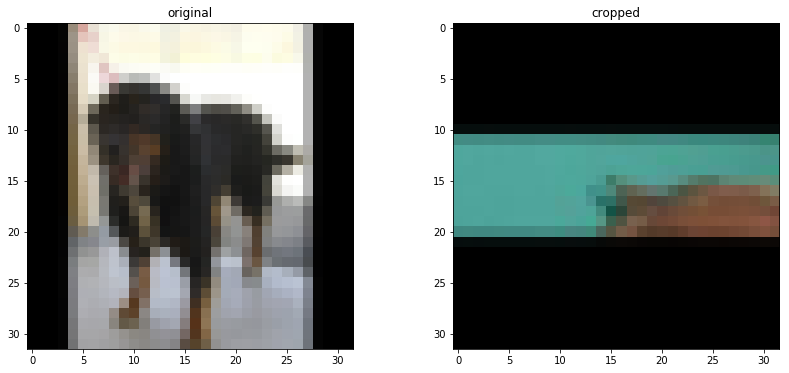

In [6]:
plot(ds, 0)

(tensor([ 1]), tensor([ 1]), tensor([ 0.2988,  0.6093]))


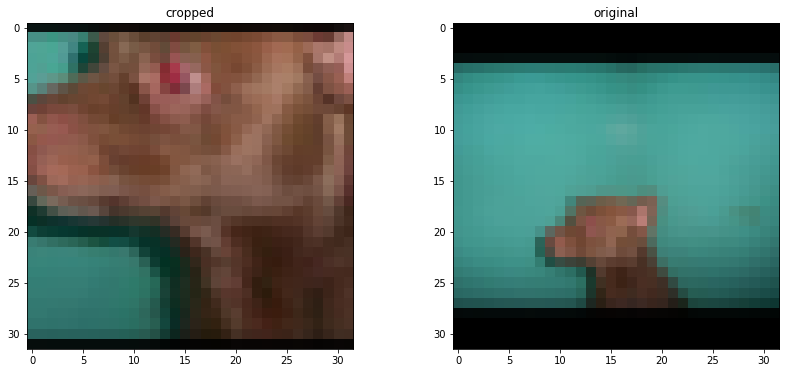

In [7]:
plot(ds, 1)

(tensor([ 1]), tensor([ 0]), tensor([ 0.3096,  0.0453]))


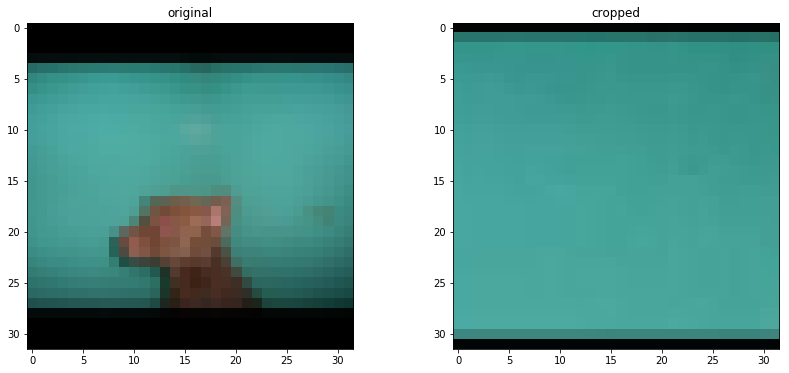

In [8]:
plot(ds, 9)

In [9]:
try:
    plot(ds, 80)
except Exception as e:
    print(e)

Index 80 out of range [0-79]


In [10]:
def flat_plot(ds, index):
    sample, target = ds[index]
    print(target)

    # imshow wants (w, h, channels), torch wants (channels, w, h)
    i = sample.permute((1,2,0))
    plt.imshow(i)

In [11]:
flat_ds = CroppedPairs(root='data/dogscats/sample/train/dogs', image_size=32, cat_dim=2)

(tensor([ 0]), tensor([ 0]), tensor([ 0.3636,  0.5741]))


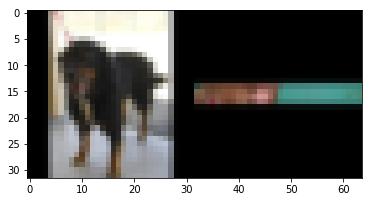

In [12]:
flat_plot(flat_ds, 0)